<a href="https://colab.research.google.com/github/Hikaros/ML-Forex-Time-Series-Predictions/blob/master/Multi_variable_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()
!ls
# !rm EURUSD.csv

Saving Convert_Series_To_Supervised_Learning.py to Convert_Series_To_Supervised_Learning.py
Saving EURUSD.csv to EURUSD.csv
Saving GBP_USD Historical Data.csv to GBP_USD Historical Data.csv
Saving Hikaros_forex_functions.py to Hikaros_forex_functions.py
Saving technical_indicators.py to technical_indicators.py
Saving US Dollar Index Historical Data.csv to US Dollar Index Historical Data.csv
Saving USD_CHF Historical Data.csv to USD_CHF Historical Data.csv
 Convert_Series_To_Supervised_Learning.py
 EURUSD.csv
'GBP_USD Historical Data.csv'
 Hikaros_forex_functions.py
 sample_data
 technical_indicators.py
'USD_CHF Historical Data.csv'
'US Dollar Index Historical Data.csv'


In [0]:
import math
import os
import numpy as np
import pandas as pd
from Hikaros_forex_functions import dukascopy_data_man
from Convert_Series_To_Supervised_Learning import series_to_supervised
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from scipy.signal import argrelextrema
from keras.layers import Embedding
from pandas import DataFrame
from pandas import read_csv
from datetime import datetime
from technical_indicators import relative_strength_index
from technical_indicators import donchian_channel

Using TensorFlow backend.


In [0]:
USDX=read_csv("US Dollar Index Historical Data.csv")

USDX['Date'] = pd.to_datetime(USDX['Date'])
USDX = USDX.set_index(USDX["Date"])
# USDX.drop(["Date","Open","High","Low"],axis=1,inplace=True)

In [0]:
USDCHF=read_csv('USD_CHF Historical Data.csv')

USDCHF['Date'] = pd.to_datetime(USDCHF['Date'])
USDCHF = USDCHF.set_index(USDCHF["Date"])
# USDCHF.drop(["Date","Open","High","Low"],axis=1,inplace=True)

In [0]:
GBPUSD=read_csv('GBP_USD Historical Data.csv')

GBPUSD['Date'] = pd.to_datetime(GBPUSD['Date'])
GBPUSD = GBPUSD.set_index(GBPUSD["Date"])
# GBPUSD.drop(["Date","Open","High","Low"],axis=1,inplace=True)


In [0]:
# Dataset
dataset = read_csv("EURUSD.csv")
# Set RSI
dataset["RSI"]=relative_strength_index(dataset,14)["RSI_14"]
# dataset["Don_Channel"] = donchian_channel(dataset,14)["Donchian_14"]
# dataset["Don_Channel"] = dataset["Don_Channel"].replace(0,0.0469)
# print(Don)
# dataset["USDX"] = USDX["Close"]
# dataset["GBPUSD"] = GBPUSD["Close"]
# index Date
dataset["Date"]=pd.to_datetime(dataset["Date"],format="%Y.%m.%d")
dataset = dataset.set_index(dataset["Date"])
dataset.drop(["Date","Open","High","Low"],axis=1,inplace=True)
# Add Varialbles
dataset["USDX"] = USDX["Close"]
dataset["USDCHF"] = USDCHF["Close"]
# dataset["GBPUSD"] = GBPUSD["Close"]
# dataset["EURUSD"] = dataset["Close"]
# Fill zeros
dataset['RSI'].fillna(method='bfill', inplace=True)
dataset['USDX'].fillna(method='ffill', inplace=True)
dataset['USDCHF'].fillna(method='ffill', inplace=True)
dataset['USDCHF'].fillna(method='bfill', inplace=True)
# dataset['GBPUSD'].fillna(method='ffill', inplace=True)
# dataset['GBPUSD'].fillna(method='bfill', inplace=True)
n_features=dataset.shape[1]
# dataset

In [0]:
price = dataset.values[:,0].copy()

max_idx = list(argrelextrema(price, np.greater, order=10)[0])
min_idx = list(argrelextrema(price, np.less, order=10)[0])
idx = max_idx + min_idx
idx.sort()
peaks=price[idx]

for i in range(len(price)):
  if i not in idx: 
    price[i] =np.nan
  
print(price)
dataset["Peaks"] = price
dataset['Peaks'].fillna(method='ffill', inplace=True)
dataset['Peaks'].fillna(method='bfill', inplace=True)
# dataset['USDX'].fillna(method='ffill', inplace=True)
dataset

[   nan 1.1309    nan ...    nan    nan    nan]


,Close,RSI,USDX,USDCHF,Peaks
Date,,,,,
1990-01-01,1.14260,0.335846,93.21,1.5813,1.13090
1990-01-02,1.13090,0.335846,94.29,1.5813,1.13090
1990-01-03,1.16720,0.335846,94.42,1.5794,1.13090
1990-01-04,1.15920,0.335846,92.52,1.5373,1.13090
1990-01-07,1.17240,0.335846,92.52,1.5373,1.17240
...,...,...,...,...,...
2019-12-31,1.12154,0.867247,96.73,0.9680,1.12154
2020-01-02,1.11712,0.700157,96.48,0.9714,1.12154
2020-01-03,1.11564,0.563211,96.79,0.9727,1.12154


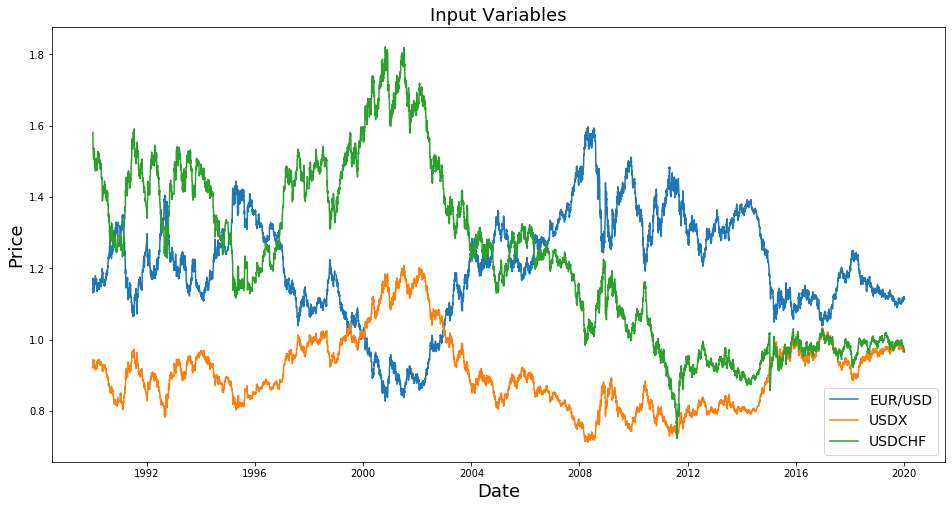

In [0]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Input Variables', fontsize=18)
# plt.plot(dataset["Peaks"])
plt.plot(dataset["Close"])
# plt.plot(dataset["GBPUSD"])
plt.plot(dataset["USDX"]*0.01)
plt.plot(dataset["USDCHF"])
# plt.plot(dataset[["Peaks","Close"]][-200:])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.legend(["EUR/USD", 'USDX',"USDCHF"], loc='lower right',fontsize=14)
plt.show()

In [0]:
# ensure all data is float
values = dataset.values
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
n_hours = 1

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed)

# drop columns we don't want to predict
reframed.drop(reframed.columns[-n_features:], axis=1, inplace=True)
print(reframed)
print(reframed["var1(t-1)"])
reframed.shape


      var1(t-1)  var2(t-1)  var3(t-1)  ...   var3(t)   var4(t)   var5(t)
1      0.408890   0.319149   0.441396  ...  0.463183  0.781156  0.393683
2      0.393683   0.319149   0.463183  ...  0.465806  0.779426  0.393683
3      0.440863   0.319149   0.465806  ...  0.427476  0.741101  0.393683
4      0.430465   0.319149   0.427476  ...  0.427476  0.741101  0.447621
5      0.447621   0.319149   0.427476  ...  0.417995  0.729449  0.447621
...         ...        ...        ...  ...       ...       ...       ...
8772   0.379465   0.862825   0.518257  ...  0.512407  0.222849  0.381518
8773   0.381518   0.880017   0.512407  ...  0.507363  0.225944  0.381518
8774   0.375773   0.703661   0.507363  ...  0.513617  0.227128  0.381518
8775   0.373850   0.559122   0.513617  ...  0.515836  0.223031  0.381518
8776   0.378906   0.619480   0.515836  ...  0.510793  0.224943  0.381518

[8776 rows x 10 columns]
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1      0.408890   0.319149  

(8776, 6)

In [0]:
# split into train and test sets
values = reframed.values
n_train_hours = int(values.shape[0]/8776*7000)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7000, 4) 7000 (7000,)
(7000, 1, 4) (7000,) (1776, 1, 4) (1776,)


In [0]:
print(n_train_hours)

7000


In [0]:
# design network
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(128, return_sequences= False))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 32)             4736      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             24832     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 128,513
Trainable params: 128,513
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 7000 samples, validate on 1776 samples
Epoch 1/150





 - 5s - loss: 0.0410 - val_loss: 0.0317
Epoch 2/150
 - 2s - loss: 0.0163 - val_loss: 0.0206
Epoch 3/150
 - 2s - loss: 0.0084 - val_loss: 0.0093
Epoch 4/150
 - 2s - loss: 0.0027 - val_loss: 0.0029
Epoch 5/150
 - 2s - loss: 6.6327e-04 - val_loss: 0.0010
Epoch 6/150
 - 2s - loss: 3.6174e-04 - val_loss: 6.4504e-04
Epoch 7/150
 - 2s - loss: 3.3921e-04 - val_loss: 6.7952e-04
Epoch 8/150
 - 2s - loss: 3.3867e-04 - val_loss: 7.9721e-04
Epoch 9/150
 - 2s - loss: 3.3919e-04 - val_loss: 9.2817e-04
Epoch 10/150
 - 2s - loss: 3.4338e-04 - val_loss: 0.0010
Epoch 11/150
 - 2s - loss: 3.5348e-04 - val_loss: 0.0011
Epoch 12/150
 - 2s - loss: 3.6726e-04 - val_loss: 0.0011
Epoch 13/150
 - 2s - loss: 3.8017e-04 - val_loss: 0.0010
Epoch 14/150
 - 2s - loss: 3.8795e-04 - val_loss: 9.3255e-04
Epoch 15/150
 - 2s - loss: 3.8881e-04 - val_loss: 8.3297e

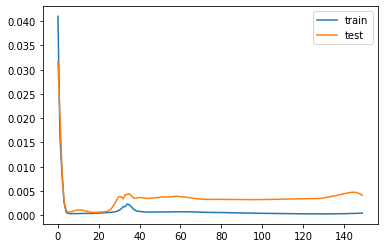

In [0]:
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()



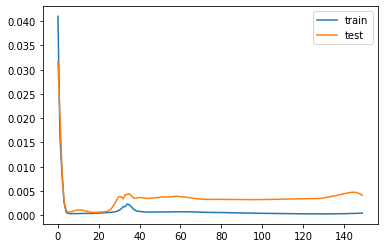

In [0]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
# print(test_X)

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
print(yhat)
# print(test_X[:, -n_features+1:])

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -n_features:]), axis=1)
print(inv_yhat)

# inv_yhat = yhat.reshape(-1,1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
print(inv_yhat)
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -n_features:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

[[0.7387892 ]
 [0.7392445 ]
 [0.7429545 ]
 ...
 [0.45002118]
 [0.44613194]
 [0.4496267 ]]
[[0.7387892  0.71632445 0.48486662 0.17268503 0.14747381]
 [0.7392445  0.718326   0.4769771  0.17409718 0.1473828 ]
 [0.7429545  0.7196127  0.5893133  0.17268503 0.1457442 ]
 ...
 [0.45002118 0.3757733  0.7036609  0.5073633  0.22594446]
 [0.44613194 0.37384975 0.55912197 0.51361704 0.22712785]
 [0.4496267  0.37890553 0.6194803  0.51583624 0.2230314 ]]
[1.3964244 1.3967748 1.3996291 ... 1.1742463 1.1712539 1.1739428]
Test RMSE: 0.049


(8777, 1)
              Close
Date               
2014-04-22  1.38068
2014-04-23  1.38167
2014-04-24  1.38302
2014-04-25  1.38330
2014-04-27  1.38387
...             ...
2019-12-31  1.12154
2020-01-02  1.11712
2020-01-03  1.11564
2020-01-06  1.11953
2020-01-07  1.11429

[1776 rows x 1 columns]
(1776,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


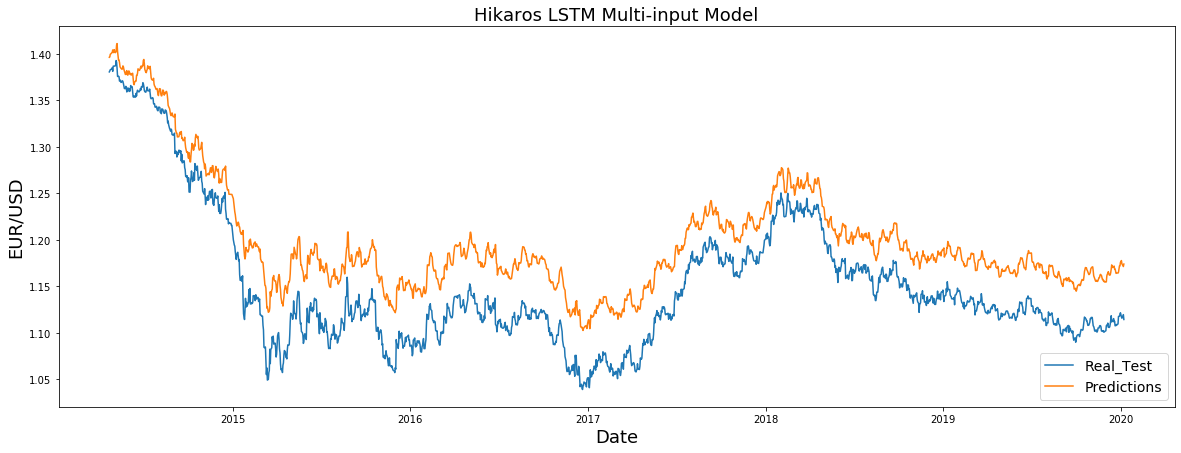

In [0]:
#Plot the data
data = dataset.filter(["Close"])
print(data.shape)
train = data[:n_train_hours]
valid = data[n_train_hours+n_hours:]
print(valid)
print(inv_yhat.shape)
valid['Predictions'] = inv_yhat
# print(valid)
#Visualize the data
plt.figure(figsize=(20,7))
plt.title('Hikaros LSTM Multi-input Model',fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('EUR/USD', fontsize=18)
# plt.plot(train[symbol])
# plt.plot(train)
plt.plot(valid[["Close","Predictions"]])
plt.legend(["Real_Test", 'Predictions'], loc='lower right' , fontsize=14)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


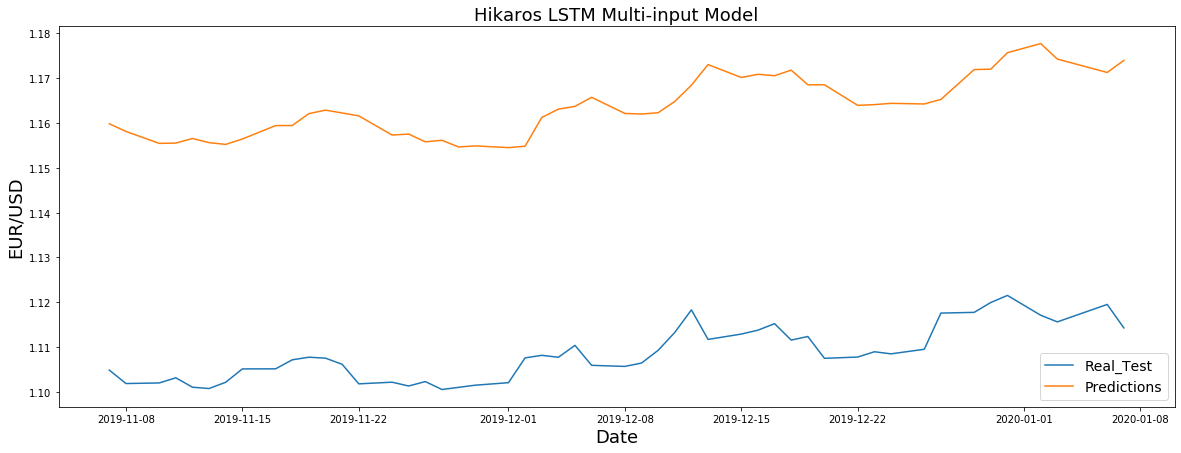

In [0]:
#Plot the data
data = dataset.filter(["Close"])
train = data[:n_train_hours]
valid = data[n_train_hours+n_hours:]
valid['Predictions'] = inv_yhat
# print(valid)
#Visualize the data
plt.figure(figsize=(20,7))
plt.title('Hikaros LSTM Multi-input Model',fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('EUR/USD', fontsize=18)
# plt.plot(train[symbol])
# plt.plot(train)
plt.plot(valid[["Close","Predictions"]][-50
                                        :])
plt.legend(["Real_Test", 'Predictions'], loc='lower right',fontsize=14)
plt.show()

(1776, 1)
(1776,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


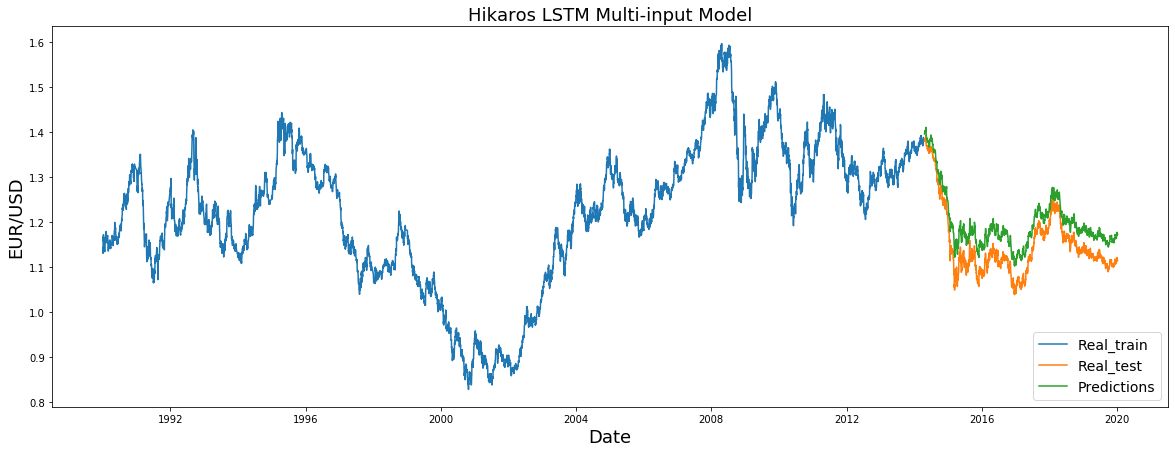

In [0]:
#Plot the data
data = dataset.filter(["Close"])
train = data[:n_train_hours]
valid = data[n_train_hours+n_hours:]
print(valid.shape)
print(inv_yhat.shape)
valid['Predictions'] = inv_yhat
# print(valid)
#Visualize the data
plt.figure(figsize=(20,7))
plt.title('Hikaros LSTM Multi-input Model',fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('EUR/USD', fontsize=18)
# plt.plot(train[symbol])
plt.plot(train)
plt.plot(valid[["Close","Predictions"]])
plt.legend(["Real_train",'Real_test', 'Predictions'], loc='lower right', fontsize=14)
plt.show()